In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# https://www.akshare.xyz/zh_CN/latest/introduction.html
import akshare as ak
import json
import pandas as pd
import numpy as np
import rui_risk_kit as rrk
import fastquotes
import matplotlib.pyplot as plt
import pypfopt
from pypfopt import plotting

# from pypfopt import black_litterman, risk_models
# from pypfopt import BlackLittermanModel, plotting

## Preparing Data

In [2]:
with open('assets.json','r') as myfile:
    data=myfile.read()

assets = json.loads(data)

# 构建开放式基金以及货币基金的列表
open_mutual_fund_list = []
currency_mutual_fund_list = []

# 将开放式基金以及货币基金合并成一个dict
portfolio = {**assets['open_fund_in_porfolio'], **assets['currency_fund_in_portfolio']}

for open_fund in assets['open_fund_in_porfolio']:
    open_mutual_fund_list.append(open_fund)

for currency_fund in assets['currency_fund_in_portfolio']:
    currency_mutual_fund_list.append(currency_fund)

In [3]:
currency_fund_info_df = rrk.get_currency_fund_values(currency_mutual_fund_list)
fund_em_info_df = rrk.get_mf_values(open_mutual_fund_list, indicator='累计净值走势')

# concatenate DataFrame(currency_fund_info_df) to Dataframe(fund_em_info_df)
fund_em_info_df = pd.concat([fund_em_info_df, currency_fund_info_df], axis=1)
portfolio_fund_list = open_mutual_fund_list + currency_mutual_fund_list

# replace NA with value from previous trading day
# fund_em_info_df.fillna(method ='ffill', inplace = True)

# use return data starting from year 2021
fund_em_info_df = fund_em_info_df["2021":]

fund_em_info_df.tail()

,004342,163406,001714,003095,003096,161725,502056,005918,002963,213009,004972
净值日期,,,,,,,,,,,
2021-07-22,2.2575,8.0426,3.984,4.126,4.075,3.0976,1.6282,1.4484,1.2816,0.5253,0.6518
2021-07-23,2.2334,7.9479,3.926,3.984,3.934,3.0640,1.5764,1.4318,1.2860,0.5803,0.6534
2021-07-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.6530
2021-07-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0575,0.6530
2021-07-26,2.1693,7.7338,3.834,3.788,3.741,2.9603,1.4990,1.3879,1.2902,0.5256,0.6683


In [4]:
# 获取基金规模，代表基金的市值，该数据每季度更新一次
mcaps = {}
for fund in portfolio_fund_list:
    mcaps[fund] = fastquotes.fund.daily.fund_size(fund) * 100000000
mcaps

{'004342': 68000000.0,
 '163406': 32054000000.000004,
 '001714': 17855000000.0,
 '003095': 26260000000.000004,
 '003096': 24238000000.0,
 '161725': 65845000000.00001,
 '502056': 420000000.0,
 '005918': 4315000000.0,
 '002963': 3049000000.0,
 '213009': 18781000000.0,
 '004972': 13941999999.999998}

In [5]:
market_prices = ak.stock_zh_index_daily_tx(symbol="sh000300")
market_prices = market_prices.drop(market_prices.columns[[0, -1, -2, -3]], axis = 1)
market_prices.tail()

100%|██████████| 17/17 [00:10<00:00,  1.55it/s]


,close
date,
2021-07-20,5108.99
2021-07-21,5144.04
2021-07-22,5151.75
2021-07-23,5089.23
2021-07-26,4925.30


## Constructing the prior

In [6]:
S = pypfopt.risk_models.CovarianceShrinkage(fund_em_info_df.dropna()).ledoit_wolf()
delta = pypfopt.black_litterman.market_implied_risk_aversion(market_prices)

# NEEDS RESEARCH. Extract value from a pandas.core.series.Series
delta = list(delta)[0]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


<AxesSubplot:>

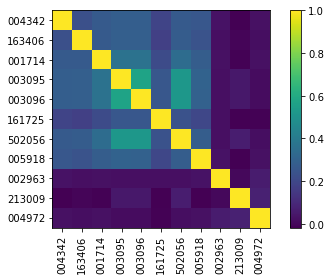

In [7]:
plotting.plot_covariance(S, plot_correlation=True)

In [8]:
market_prior = pypfopt.black_litterman.market_implied_prior_returns(mcaps, delta, S, risk_free_rate=0.023)
market_prior

004342    0.068374
163406    0.094977
001714    0.095837
003095    0.154200
003096    0.152716
161725    0.114592
502056    0.123194
005918    0.074428
002963    0.034990
213009    1.885214
004972    0.556168
dtype: float64

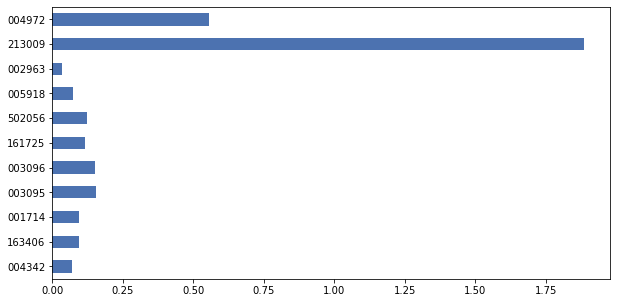

In [9]:
market_prior.plot.barh(figsize=(10,5));

## Views

In the BL method, views are specified via the matrix P (picking matrix) and the vector Q. Q contains the magnitude of each view, while P maps the views to the assets they belong to. 

If you are providing **absolute views** (i.e a return estimate for each asset), you don't have to worry about P and Q, you can just pass your views as a dictionary.

In [10]:
viewdict = {
    "001714": 0.10,
    "002963": 0.30,
    "003095": 0.05,
    "003096": 0.20,
    "004342": -0.05,
    "004972": 0.15,
    "005918": 0.10,
    "161725": 0.12,
    "163406": 0.13,
    "213009": 0.14,
    "502056": 0.10
}

bl = pypfopt.BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

Black-Litterman also allows for relative views, e.g you think asset A will outperform asset B by 10%. If you'd like to incorporate these, you will have to build P and Q yourself. An explanation for this is given in the [docs](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html#views).

## View confidences

In this section, we provide two ways that you may wish to construct the uncertainty matrix. The first is known as Idzorek's method. It allows you to specify a vector/list of percentage confidences.

In [11]:
confidences = [
    0.6,
    0.4,
    0.2,
    0.5,
    0.7, # confident in dominos
    0.7, # confident KO will do poorly
    0.7, 
    0.5,
    0.1,
    0.4,
    0.2
]

In [12]:
bl = pypfopt.BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

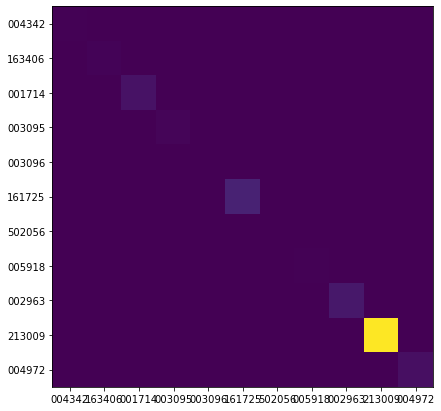

In [13]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [14]:
np.diag(bl.omega)

array([0.0049087 , 0.00827254, 0.0450521 , 0.01126064, 0.00274522,
       0.08722317, 0.00283761, 0.00647819, 0.05834288, 0.90973205,
       0.03842968])

Instead of inputting confidences, we can calculate the uncertainty matrix directly by specifying 1 standard deviation confidence intervals, i.e bounds which we think will contain the true return 68% of the time. This may be easier than coming up with somewhat arbitrary percentage confidences

In [15]:
intervals = [
    (0, 0.5),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3),
    (0, 0.3)
]

In [16]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.0625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225, 0.0225]


## Posterior estimates

Given the inputs, we can compute a posterior estimate of returns


In [17]:
# We are using the shortcut to automatically compute market-implied prior
bl = pypfopt.BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [18]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

004342   -0.016037
163406    0.075796
001714    0.079919
003095    0.112739
003096    0.162565
161725    0.118527
502056    0.096486
005918    0.084904
002963    0.065698
213009    0.200680
004972    0.153978
dtype: float64

We can visualise how this compares to the prior and our views:

In [19]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T

rets_df

,Prior,Posterior,Views
004342,0.068374,-0.016037,-0.05
163406,0.094977,0.075796,0.13
001714,0.095837,0.079919,0.10
003095,0.154200,0.112739,0.05
003096,0.152716,0.162565,0.20
161725,0.114592,0.118527,0.12
502056,0.123194,0.096486,0.10
005918,0.074428,0.084904,0.10
002963,0.034990,0.065698,0.30
213009,1.885214,0.200680,0.14


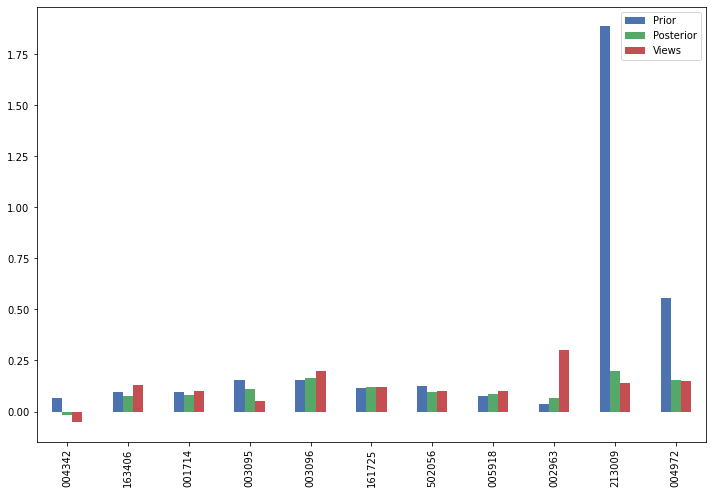

In [20]:
rets_df.plot.bar(figsize=(12,8));

Notice that the posterior is often between the prior and the views. This supports the fact that the BL method is essentially a Bayesian weighted-average of the prior and views, where the weight is determined by the confidence.

A similar but less intuitive procedure can be used to produce the posterior covariance estimate:

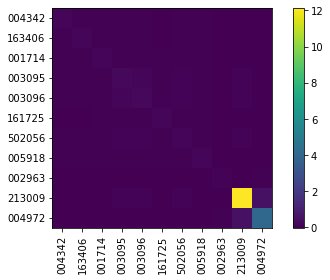

In [21]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

## Portfolio allocation

Now that we have constructed our Black-Litterman posterior estimate, we can proceed to use any of the optimizers discussed in previous recipes.

In [22]:
# from pypfopt import EfficientFrontier, objective_functions

In [23]:
ef = pypfopt.EfficientFrontier(ret_bl, S_bl)
ef.add_objective(pypfopt.objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/opt/anaconda3/lib/python3.8/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:252: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('004342', 0.0),
             ('163406', 0.07925),
             ('001714', 0.07847),
             ('003095', 0.11312),
             ('003096', 0.21196),
             ('161725', 0.16846),
             ('502056', 0.09034),
             ('005918', 0.0962),
             ('002963', 0.08445),
             ('213009', 0.02568),
             ('004972', 0.05208)])

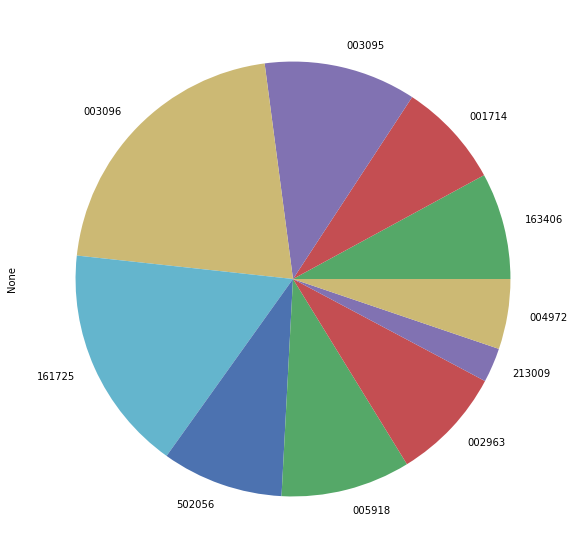

In [24]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [25]:
# get latest prices of assets, if it's not trading day, then try previous value until not "NaN"
i = 1
while fund_em_info_df.iloc[-i].isnull().values.any():
    i += 1
else:
    latest_prices = fund_em_info_df.iloc[-i]

# allocate the portfolio based on max-sharpe results to reflect units per assets
da = pypfopt.DiscreteAllocation(weights, latest_prices, total_portfolio_value=300000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ￥{leftover:.2f}")
alloc

Leftover: ￥0.12


{'163406': 3074,
 '001714': 6140,
 '003095': 8959,
 '003096': 16997,
 '161725': 17072,
 '502056': 18080,
 '005918': 20794,
 '002963': 19636,
 '213009': 14658,
 '004972': 23379}

In [26]:
total_portfolio_value = 300000

for asset, pct in weights.items():
    print(asset, pct * total_portfolio_value)

004342 0.0
163406 23775.0
001714 23541.0
003095 33936.0
003096 63588.0
161725 50538.0
502056 27102.0
005918 28859.999999999996
002963 25335.0
213009 7704.0
004972 15624.0
